In [98]:
def Graficas(hist):
  plt.title = "Función de Perdidas (Entrenamiento vs Validación)"
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.xlabel('No Epocas')
  plt.legend(['Entrenamiento', 'Validación'])
  plt.show()

  plt.title = "Métricas (Entrenamiento vs Validación)"
  plt.plot(hist.history['categorical_accuracy'])
  plt.plot(hist.history['val_categorical_accuracy'])
  plt.xlabel('No Epocas')
  plt.legend(['Entrenamiento', 'Validación'])
  plt.show()

In [99]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import random

def Evaluar_Predecir(modelo, x_data, y_data, tam):
  (validation_perdidas, validation_metricas) = modelo.evaluate(x_data, y_data, batch_size = tam)
  print("Evaluación: Perdidas [{}] Métricas [{}]".format(validation_perdidas, validation_metricas))
  y_pred = modelo.predict(x_data, batch_size = tam)


  y_real = np.argmax(y_data, axis = 1)
  y_pre = np.argmax(y_pred, axis = 1)

  res = confusion_matrix(y_real, y_pre)
  plt.imshow(res, cmap = plt.cm.Blues)

  exactitud = accuracy_score(y_real, y_pre)

  print("Exactitud [{}]". format(exactitud))

  precision = precision_score(y_real, y_pre, average = 'macro')

  print("Precision [{}]". format(precision))

In [100]:
%pip install matplotlib
%pip install opencv-python
%pip install tensorflow
%pip install scikit-learn
%pip install keras

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [101]:
#BASE_FOLDER = "C:/Users/srJ_5/OneDrive/Documentos/UNIVERSIDAD/9no semestre/TALLER 2/Reconocimiento de cicatricez/tallerScars/archive"
BASE_FOLDER = "C:/Users/Sebas/Desktop/Universidad/Taller/archive"


In [102]:
# Number of samples we will have in each class.
SAMPLE_SIZE = 319

# The images will all be resized to this size.
IMAGE_SIZE = 126

In [103]:
import shutil
import os
train_dir=BASE_FOLDER+"/train"
val_dir=BASE_FOLDER+"/val"


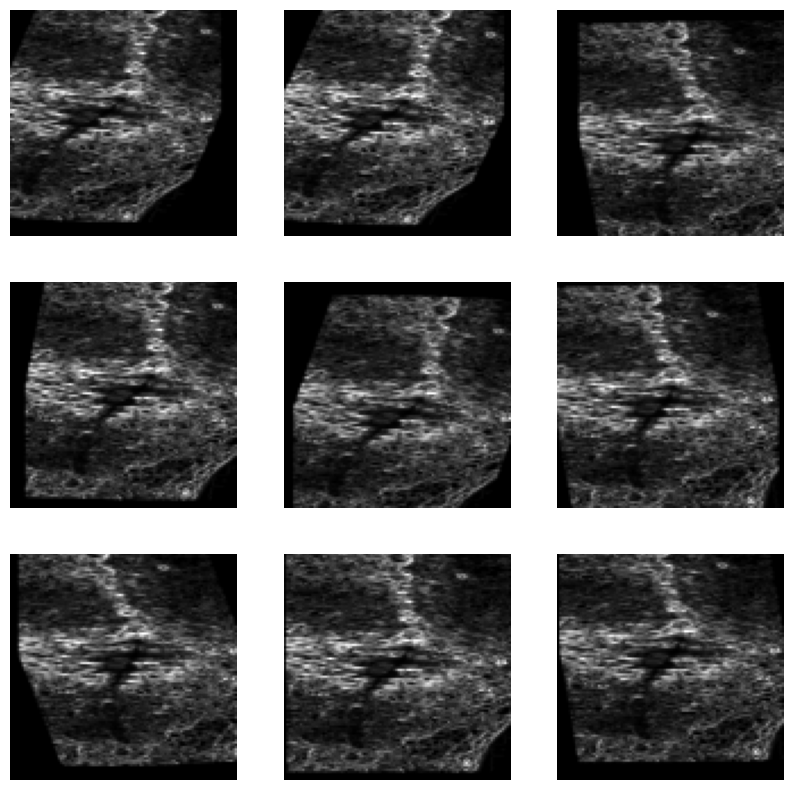

In [104]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.ndimage import filters

rotation_angle = 10
shift_range = 0.1
zoom_range = 0.1
brightness_range = (0.5, 2.0)

train_dir=BASE_FOLDER+"/train"
val_dir=BASE_FOLDER+"/val"
test_dir=BASE_FOLDER+"/test"
kernel_size = 5
dim=[100,100]
x_train=[]
def augment_image(image):
    # Rotación
    angle = np.random.uniform(-rotation_angle, rotation_angle)
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))

    # Desplazamiento
    dx = np.random.uniform(-shift_range * cols, shift_range * cols)
    dy = np.random.uniform(-shift_range * rows, shift_range * rows)
    M = np.float32([[1, 0, dx], [0, 1, dy]])
    shifted_image = cv2.warpAffine(rotated_image, M, (cols, rows))

    # Zoom
    zoom_factor = 1 + np.random.uniform(-zoom_range, zoom_range)
    resized_image = cv2.resize(shifted_image, None, fx=zoom_factor, fy=zoom_factor, interpolation=cv2.INTER_LINEAR)

    # Ajuste de brillo y contraste
    brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
    brightened_image = cv2.convertScaleAbs(resized_image, alpha=brightness_factor, beta=0)
    resized=cv2.resize(brightened_image,(100,100),interpolation = cv2.INTER_AREA)
    return resized

for i in os.listdir(train_dir):
    for j in os.listdir(os.path.join(train_dir, i)):
        image = cv2.imread(os.path.join(train_dir, i, j), cv2.IMREAD_GRAYSCALE)
        for _ in range(10):  
            image=cv2.equalizeHist(image)
            imagen_suavizada = cv2.medianBlur(image, 5)

            sobelx = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=5)
            gradiente_magnitud = np.sqrt(sobelx**2 + sobely**2)
            gradiente_magnitud = cv2.normalize(gradiente_magnitud, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image = augment_image(gradiente_magnitud)
           

            x_train.append(augmented_image)
num_images = 9
plt.figure(figsize=(10, 10))  

for i in range(num_images):
    plt.subplot(3, 3, i + 1)  
    plt.imshow(x_train[i+10], cmap='gray') 
    plt.axis('off')  # Apagar ejes

plt.show()


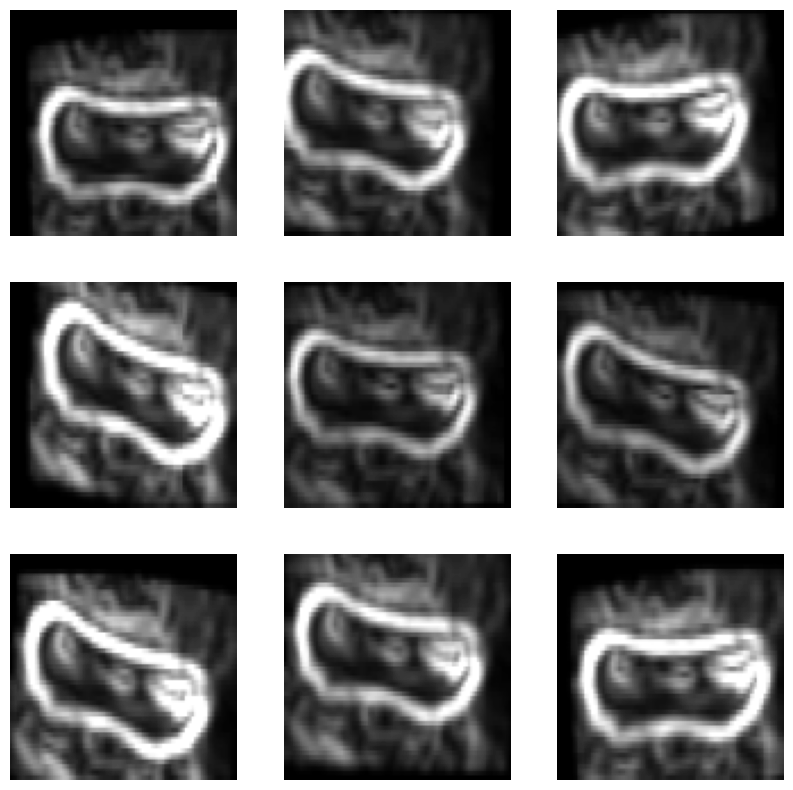

In [105]:
x_val=[]
for i in os.listdir(val_dir):
    for j in os.listdir(os.path.join(val_dir, i)):
        image = cv2.imread(os.path.join(val_dir, i, j), cv2.IMREAD_GRAYSCALE)

        for _ in range(10):  
            image=cv2.equalizeHist(image)

            imagen_suavizada = cv2.GaussianBlur(image, (3, 3), 0)

            sobelx = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=5)
            gradiente_magnitud = np.sqrt(sobelx**2 + sobely**2)
            gradiente_magnitud = cv2.normalize(gradiente_magnitud, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image = augment_image(gradiente_magnitud)
            x_val.append(augmented_image)
num_images = 9
plt.figure(figsize=(10, 10)) 

for i in range(num_images):
    plt.subplot(3, 3, i + 1)  
    plt.imshow(x_val[i+10], cmap='gray') 
    plt.axis('off')  

In [106]:
x_test=[]
for i in os.listdir(test_dir):
    for j in os.listdir(os.path.join(test_dir, i)):
        image = cv2.imread(os.path.join(test_dir, i, j), cv2.IMREAD_GRAYSCALE)

       
        for _ in range(10):  
            image=cv2.equalizeHist(image)

            imagen_suavizada = cv2.GaussianBlur(image, (3, 3), 0)

            sobelx = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(imagen_suavizada, cv2.CV_64F, 0, 1, ksize=5)
            gradiente_magnitud = np.sqrt(sobelx**2 + sobely**2)
            gradiente_magnitud = cv2.normalize(gradiente_magnitud, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            augmented_image = augment_image(gradiente_magnitud)

            x_test.append(augmented_image)


In [107]:
x_train=np.array(x_train)
x_val=np.array(x_val)
x_test=np.array(x_test)

In [108]:
print(x_train.dtype)
print(x_train.shape)

uint8
(7080, 100, 100)


In [109]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_val=x_val.astype("float32")

In [110]:
x_train = x_train/255
x_val = x_val/255
x_test=x_test/255


In [111]:
x_val[0]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.11764706, 0.09019608,
        0.05882353],
       [0.        , 0.        , 0.        , ..., 0.11372549, 0.08627451,
        0.05098039],
       [0.        , 0.        , 0.        , ..., 0.11372549, 0.08235294,
        0.04705882]], dtype=float32)

CREAMOS LAS CATERGORIAS

In [112]:
import tensorflow as tf
y_train = tf.keras.utils.to_categorical([0,1], 2)

y_train_new=[]
for i in y_train:
  for j in range(354*10):
    y_train_new.append(i)
y_train=np.array(y_train_new)


In [113]:
y_val = tf.keras.utils.to_categorical([0,1], 2)

y_val_new=[]
for i in y_val:
  for j in range(126*10):
    y_val_new.append(i)
y_val=np.array(y_val_new)

In [114]:
y_test = tf.keras.utils.to_categorical([0,1], 2)

y_test_new=[]
for i in y_test:
  for j in range(14*10):
    y_test_new.append(i)
y_test=np.array(y_test_new)

In [115]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D

model = Sequential()

# Extracción de características
model.add(Flatten(input_shape = (100, 100, 1), name = "Entrada"))
model.add(Dense(256, activation="relu", kernel_initializer= 'glorot_uniform', bias_initializer= 'glorot_uniform', name = "Oculta_No_1"))
model.add(Dense(128, activation="relu", name = "Oculta_No_2"))
model.add(Dense(64, activation="relu", name = "Oculta_No_3"))
model.add(Dense(32, activation="relu", name = "Oculta_No_4"))
model.add(Dense(2, activation="sigmoid", name = "Salida"))
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Entrada (Flatten)           (None, 10000)             0         
                                                                 
 Oculta_No_1 (Dense)         (None, 256)               2560256   
                                                                 
 Oculta_No_2 (Dense)         (None, 128)               32896     
                                                                 
 Oculta_No_3 (Dense)         (None, 64)                8256      
                                                                 
 Oculta_No_4 (Dense)         (None, 32)                2080      
                                                                 
 Salida (Dense)              (None, 2)                 66        
                                                                 
Total params: 2603554 (9.93 MB)
Trainable params: 2603

In [116]:
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [117]:


# Print dataset sizes
print("Training data size:", len(x_train))
print("Training data size:", len(y_train))

print("Validation data size:", len(x_val))

print("Validation data size:", len(y_val))

Training data size: 7080
Training data size: 7080
Validation data size: 2520
Validation data size: 2520


In [118]:
import tensorflow as tf


callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'
callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

hist = model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
111/111 [==============================] - 5s 24ms/step - loss: 0.7112 - categorical_accuracy: 0.5218 - val_loss: 0.7002 - val_categorical_accuracy: 0.5095
Epoch 2/100
111/111 [==============================] - 2s 20ms/step - loss: 0.6788 - categorical_accuracy: 0.5606 - val_loss: 0.7038 - val_categorical_accuracy: 0.4964
Epoch 3/100
111/111 [==============================] - 2s 21ms/step - loss: 0.6691 - categorical_accuracy: 0.5853 - val_loss: 0.7090 - val_categorical_accuracy: 0.5167
Epoch 4/100
111/111 [==============================] - 2s 20ms/step - loss: 0.6681 - categorical_accuracy: 0.5871 - val_loss: 0.7334 - val_categorical_accuracy: 0.5103
Epoch 5/100
111/111 [==============================] - 2s 21ms/step - loss: 0.6581 - categorical_accuracy: 0.5942 - val_loss: 0.7414 - val_categorical_accuracy: 0.5254
Epoch 6/100
111/111 [==============================] - 2s 19ms/step - loss: 0.6558 - categorical_accuracy: 0.6089 - val_loss: 0.7196 - val_categorical_accuracy:

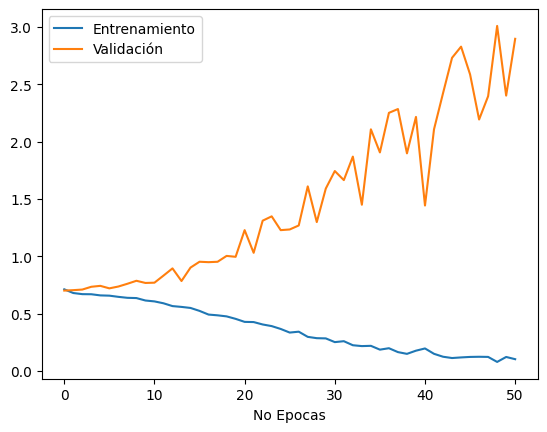

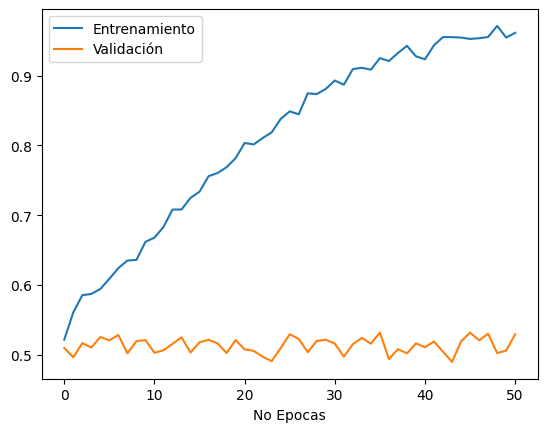

In [119]:
Graficas(hist)

5/5 [==============================] - 0s 6ms/step - loss: 2.5035 - categorical_accuracy: 0.5750
Evaluación: Perdidas [2.503549814224243] Métricas [0.574999988079071]
5/5 [==============================] - 0s 8ms/step
Exactitud [0.575]
Precision [0.5774703557312253]


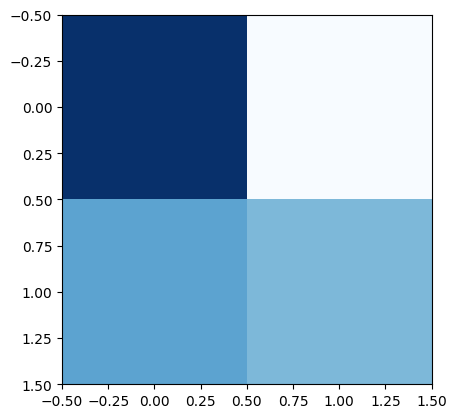

In [120]:
Evaluar_Predecir(model, x_test, y_test, 64)

MODELO 2

In [121]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout

model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape = (100, 100, 1), name = "Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters=10, kernel_size=5, strides=(2, 2), padding='valid', activation='relu', name="Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size=(4, 4), name='MaxPool_No_1'))

# Clasificación
model_conv.add(Flatten(name="Flatten"))
model_conv.add(Dense(512, activation="relu", name="Clasificacion"))
model_conv.add(Dense(2, activation="sigmoid", name="Salida"))
model_conv.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 48, 48, 10)        260       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 12, 12, 10)        0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 1440)              0         
                                                                 
 Clasificacion (Dense)       (None, 512)               737792    
                                                                 
 Salida (Dense)              (None, 2)                 1026      
                                                                 
Total params: 739078 (2.82 MB)
Trainable params: 739078 (2.82 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [122]:
model_conv.compile(optimizer='SGD', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [123]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])
model_conv.save("modeloValido.h5")

Epoch 1/100
111/111 [==============================] - 3s 22ms/step - loss: 0.6898 - categorical_accuracy: 0.5401 - val_loss: 0.6849 - val_categorical_accuracy: 0.6008
Epoch 2/100
111/111 [==============================] - 2s 18ms/step - loss: 0.6816 - categorical_accuracy: 0.5870 - val_loss: 0.6758 - val_categorical_accuracy: 0.6329
Epoch 3/100
111/111 [==============================] - 2s 18ms/step - loss: 0.6743 - categorical_accuracy: 0.5944 - val_loss: 0.6687 - val_categorical_accuracy: 0.6163
Epoch 4/100
111/111 [==============================] - 2s 19ms/step - loss: 0.6685 - categorical_accuracy: 0.5903 - val_loss: 0.6655 - val_categorical_accuracy: 0.6369
Epoch 5/100
111/111 [==============================] - 2s 19ms/step - loss: 0.6634 - categorical_accuracy: 0.6076 - val_loss: 0.6632 - val_categorical_accuracy: 0.6401
Epoch 6/100
111/111 [==============================] - 2s 18ms/step - loss: 0.6596 - categorical_accuracy: 0.6062 - val_loss: 0.6658 - val_categorical_accuracy:

c:\Users\Sebas\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


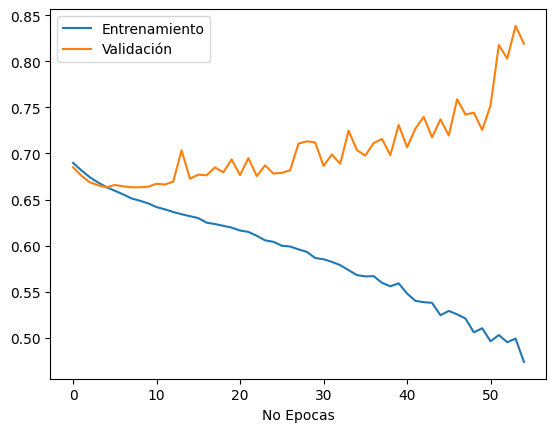

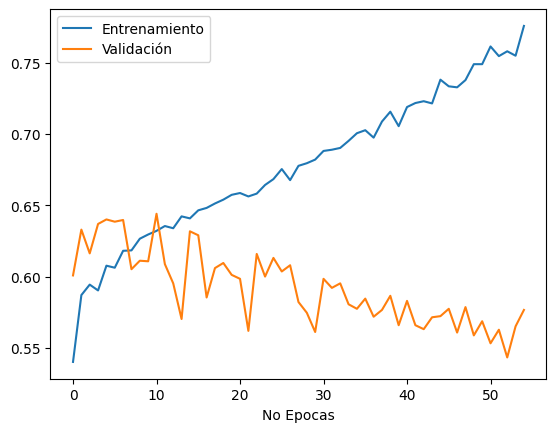

In [124]:
Graficas(hist_conv)

5/5 [==============================] - 0s 7ms/step - loss: 0.6511 - categorical_accuracy: 0.6393
Evaluación: Perdidas [0.6511456370353699] Métricas [0.6392857432365417]
5/5 [==============================] - 0s 6ms/step
Exactitud [0.6392857142857142]
Precision [0.7492923020728701]


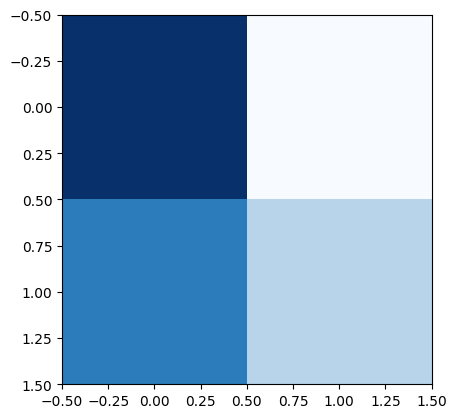

In [125]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

In [126]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout

model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape = (100, 100, 1), name = "Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters = 20, kernel_size = 4, strides = (3,3), padding = 'valid', name = "Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size = (4,4), name = 'MaxPool_No_1'))

# Clasificación
model_conv.add(Flatten(input_shape = (3,3,10), name = "Entrada_clasif"))
model_conv.add(Dense(512, activation="relu", name = "Clasificacion"))
model_conv.add(Dense(2, activation="sigmoid", name = "Salida"))
model_conv.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 33, 33, 20)        340       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 8, 8, 20)          0         
 )                                                               
                                                                 
 Entrada_clasif (Flatten)    (None, 1280)              0         
                                                                 
 Clasificacion (Dense)       (None, 512)               655872    
                                                                 
 Salida (Dense)              (None, 2)                 1026      
                                                                 
Total params: 657238 (2.51 MB)
Trainable params: 657238 (2.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [127]:
model_conv.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [128]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

Epoch 1/100
111/111 [==============================] - 3s 17ms/step - loss: 0.6536 - categorical_accuracy: 0.6102 - val_loss: 0.6827 - val_categorical_accuracy: 0.6004
Epoch 2/100
111/111 [==============================] - 1s 13ms/step - loss: 0.6066 - categorical_accuracy: 0.6576 - val_loss: 0.6700 - val_categorical_accuracy: 0.6052
Epoch 3/100
111/111 [==============================] - 1s 12ms/step - loss: 0.5513 - categorical_accuracy: 0.7065 - val_loss: 0.7059 - val_categorical_accuracy: 0.5944
Epoch 4/100
111/111 [==============================] - 1s 13ms/step - loss: 0.4920 - categorical_accuracy: 0.7593 - val_loss: 0.7145 - val_categorical_accuracy: 0.6095
Epoch 5/100
111/111 [==============================] - 1s 14ms/step - loss: 0.4199 - categorical_accuracy: 0.8073 - val_loss: 0.7435 - val_categorical_accuracy: 0.6135
Epoch 6/100
111/111 [==============================] - 1s 12ms/step - loss: 0.3338 - categorical_accuracy: 0.8637 - val_loss: 0.8018 - val_categorical_accuracy:

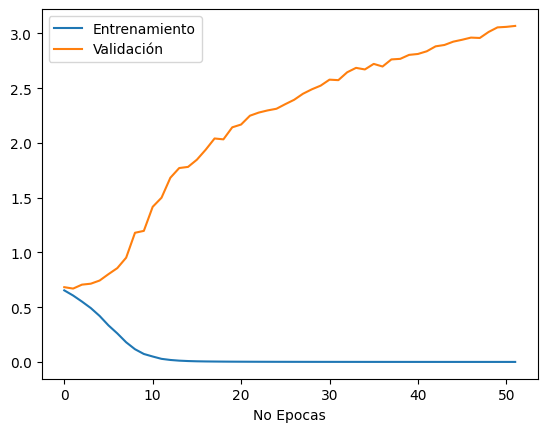

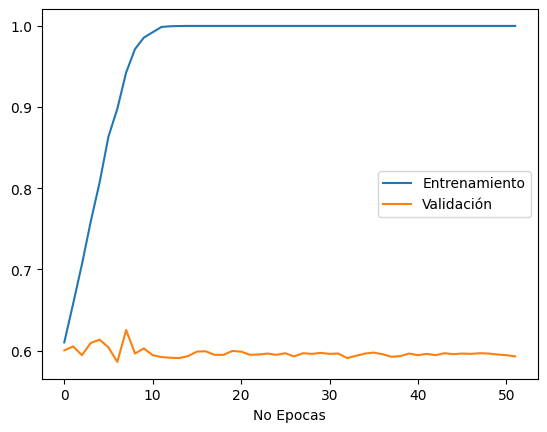

In [129]:
Graficas(hist_conv)

5/5 [==============================] - 0s 4ms/step - loss: 2.0458 - categorical_accuracy: 0.7071
Evaluación: Perdidas [2.0457844734191895] Métricas [0.7071428298950195]
5/5 [==============================] - 0s 4ms/step
Exactitud [0.7071428571428572]
Precision [0.7374269005847953]


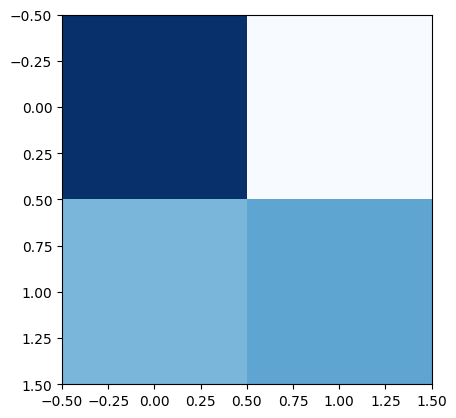

In [130]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Crear el modelo
model_conv = Sequential()

# Extracción de características
model_conv.add(Input(shape=(100, 100, 1), name="Entrada"))

# Bloque Convolucional No 1
model_conv.add(Conv2D(filters=20, kernel_size=4, strides=(3, 3), padding='valid', name="Conv_No_1"))
model_conv.add(MaxPooling2D(pool_size=(4, 4), name='MaxPool_No_1'))

# Bloque 2
model_conv.add(Conv2D(filters=10, kernel_size=2, strides=(2, 2), padding='valid', name="Conv_No_2"))
model_conv.add(MaxPooling2D(pool_size=(3, 3), name='MaxPool_No_2'))

# Clasificación
model_conv.add(Flatten(name="Flatten"))
model_conv.add(Dense(512, activation="relu", name="Clasificacion"))
model_conv.add(Dense(256, activation="relu", name="Clasificacion2"))
model_conv.add(Dense(128, activation="relu", name="Clasificacion3"))
model_conv.add(Dense(2, activation="sigmoid", name="Salida"))

# Mostrar resumen del modelo
model_conv.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_No_1 (Conv2D)          (None, 33, 33, 20)        340       
                                                                 
 MaxPool_No_1 (MaxPooling2D  (None, 8, 8, 20)          0         
 )                                                               
                                                                 
 Conv_No_2 (Conv2D)          (None, 4, 4, 10)          810       
                                                                 
 MaxPool_No_2 (MaxPooling2D  (None, 1, 1, 10)          0         
 )                                                               
                                                                 
 Flatten (Flatten)           (None, 10)                0         
                                                                 
 Clasificacion (Dense)       (None, 512)             

In [132]:
model_conv.compile(optimizer='RMSprop', loss='CategoricalCrossentropy', metrics='CategoricalAccuracy')

In [133]:
callBack_ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 50)

checkpoint_filepath = 'C:/tmp/checkpoints/checkpoint_temp'

callBack_Pesos = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_filepath, save_weights_only=True, monitor = 'val_categorical_accuracy', mode = 'max', save_best_only=True)

# hist_conv = model_conv.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])

hist_conv = model_conv.fit(x_train, y_train, batch_size = 64, epochs=100, validation_data=(x_val, y_val), callbacks = [callBack_ES, callBack_Pesos])
model_conv.save('mymodel.hs')

Epoch 1/100
111/111 [==============================] - 3s 18ms/step - loss: 0.6820 - categorical_accuracy: 0.5410 - val_loss: 0.6640 - val_categorical_accuracy: 0.6016
Epoch 2/100
111/111 [==============================] - 2s 14ms/step - loss: 0.6616 - categorical_accuracy: 0.5977 - val_loss: 0.6793 - val_categorical_accuracy: 0.5702
Epoch 3/100
111/111 [==============================] - 2s 14ms/step - loss: 0.6549 - categorical_accuracy: 0.6075 - val_loss: 0.6636 - val_categorical_accuracy: 0.6135
Epoch 4/100
111/111 [==============================] - 2s 14ms/step - loss: 0.6523 - categorical_accuracy: 0.6073 - val_loss: 0.6600 - val_categorical_accuracy: 0.6290
Epoch 5/100
111/111 [==============================] - 1s 13ms/step - loss: 0.6474 - categorical_accuracy: 0.6167 - val_loss: 0.7204 - val_categorical_accuracy: 0.5647
Epoch 6/100
111/111 [==============================] - 2s 14ms/step - loss: 0.6441 - categorical_accuracy: 0.6162 - val_loss: 0.6802 - val_categorical_accuracy:

INFO:tensorflow:Assets written to: mymodel.hs\assets


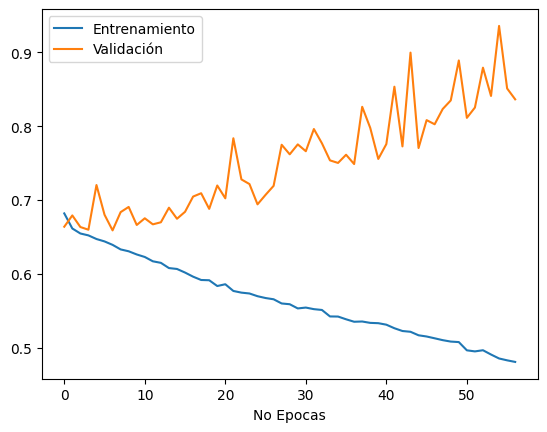

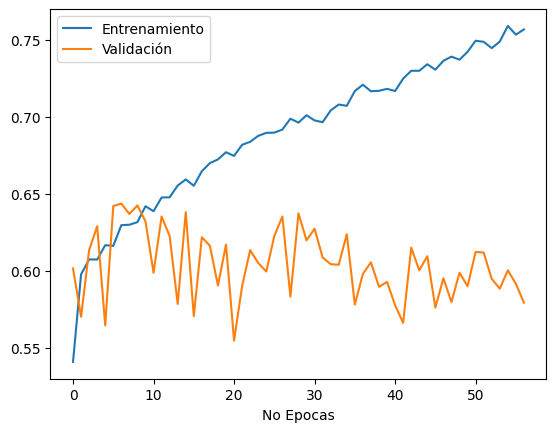

In [134]:
Graficas(hist_conv)

5/5 [==============================] - 0s 5ms/step - loss: 0.7115 - categorical_accuracy: 0.6143
Evaluación: Perdidas [0.7115390300750732] Métricas [0.6142857074737549]
5/5 [==============================] - 0s 5ms/step
Exactitud [0.6142857142857143]
Precision [0.6223776223776224]


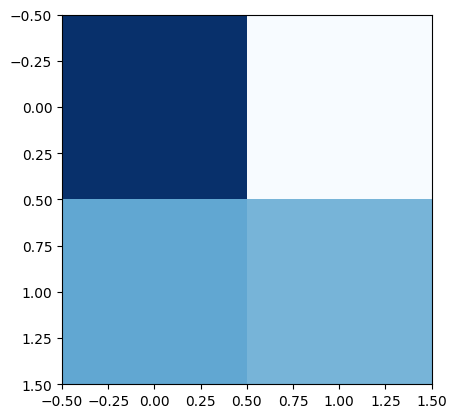

In [135]:
Evaluar_Predecir(model_conv, x_test, y_test, 64)